In [1]:
import numpy as np

import matplotlib.pyplot as plt

import copy, time
import random

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# np.random.seed(1001)
# random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1500
signal_to_noise = 4


nsamples = 20
L = 10

# ranks = np.array([5, 4, 3, 3, 2, 2, 2, 2, 1])
ranks = np.array([5, 5, 5, 4, 3, 3, 3, 3, 2, 1])
# ranks = np.array([10, 10, 10, 4, 3, 3, 3, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
# for ngroups in [2, 5, 9, 17, 33, 65, 129, 257, n+1]:
for ngroups in [2, 5, 9, 17, 33, 65, 129, 257, 513, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1500.0
level=1, num_groups=4, mean_size=375.0
level=2, num_groups=8, mean_size=187.5
level=3, num_groups=16, mean_size=93.8
level=4, num_groups=32, mean_size=46.9
level=5, num_groups=64, mean_size=23.4
level=6, num_groups=128, mean_size=11.7
level=7, num_groups=256, mean_size=5.9
level=8, num_groups=512, mean_size=2.9
level=9, num_groups=1500, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=32.88061988734488, noise_var=8.242153957034303
SNR=3.9893236717912517, signal_to_noise=4


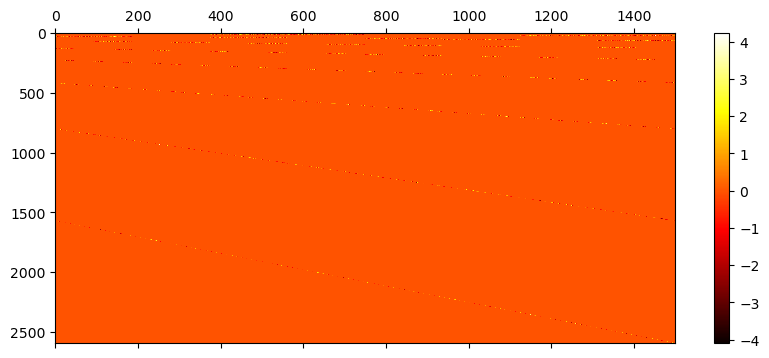

(1500, 2593)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [8]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=10, num_sparsities=512
(512, 9) [  0   3   7  15  31  63 127 255 511]


In [9]:
for _ in range(5):
    true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=False)
    true_compressed_F = true_mlr.B[:, :-1]
    F_Lm1, D = true_compressed_F+0, true_D_noise+0
    pi = F_hpart['pi']
    F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]

    ranks_F = ranks + 0
    true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
    true_mfm.inv_coefficients() 

    F_Lm1 = true_mfm.F 
    D = true_mfm.D 

    B_L = true_mfm.inv_B + 0
    B_L[:, :-1] /= 3
    C_L = true_mfm.inv_C 
    F_L = np.concatenate([F_Lm1, np.sqrt(D).reshape(-1, 1)], axis=1)

    reldiff = mfm.sp_loss_iter_refinement(F_Lm1, B_L, C_L, D, F_hpart, true_mfm.inv_hpart, ranks_F, true_mfm.inv_ranks)
    reldiff2 = mfm.loss_iter_refinement(F_L, B_L, C_L, F_hpart, true_mfm.inv_hpart, ranks_F, true_mfm.inv_ranks, 
                                        true_mfm.si_groups, true_mfm.row_selectors, debug=True)
    print(reldiff, reldiff2)
    assert np.allclose(reldiff, reldiff2)

print("PASSED")

signal_var=33.160387436617846, noise_var=8.170880182078161
SNR=4.05836173064331, signal_to_noise=4
1353.5034813680807 1353.5034813680775
signal_var=32.78821449269656, noise_var=8.029390964041237
SNR=4.083524471474243, signal_to_noise=4
283.84969490465943 283.8496949046588
signal_var=33.225009366227724, noise_var=8.387865776012518
SNR=3.9610802382227033, signal_to_noise=4
2270.3323815728113 2270.3323815728118
signal_var=32.84058656229013, noise_var=8.290078687774013
SNR=3.9614324301556447, signal_to_noise=4
597.5344850628019 597.5344850628012
signal_var=32.970915186976406, noise_var=8.444015309083511
SNR=3.9046489116982634, signal_to_noise=4
83.83672640902975 83.83672640902965
PASSED


# $$ \Delta = \tilde \Sigma^{-1}(I - \Sigma \tilde \Sigma^{-1}) $$

In [10]:
true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
true_mfm.inv_coefficients(refine=True, printing=True, eps=-1e-16, max_iter=2) 

reldiff=0.0, ranks.sum()=34
t=0, reldiff=9.837985363253421e-10, ranks.sum()=133
t=1, reldiff=0.0, ranks.sum()=430
terminated with reldiff=0.0


In [11]:
tilde_B = mf.convert_compressed_to_sparse(true_mfm.inv_B, hpart["rows"], true_mfm.inv_ranks)
tilde_C = mf.convert_compressed_to_sparse(true_mfm.inv_C, hpart["rows"], true_mfm.inv_ranks)
Sigma_inv = tilde_B @ tilde_C.T

np.allclose(Sigma_inv.toarray(), Sigma_inv.T.toarray())

True

In [12]:
mlr_inv = mf.MLRMatrix(B=true_mfm.inv_B, C=true_mfm.inv_C, hpart=hpart, ranks=true_mfm.inv_ranks)
mlr_inv.construct_sparse_format()
true_mlr.construct_sparse_format()
print(mlr_inv.ranks, true_mlr.ranks)

for _ in range(10):
    v = np.random.randn(n, 1)
    hat_x = mlr_inv.matvec(v)
    reldiff = np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(), v)) / np.linalg.norm(v)
    print(f"{reldiff=}")
    assert reldiff < 1e-9

[65 65 65 52 39 39 39 39 26  1] [5 5 5 4 3 3 3 3 2 1]
reldiff=3.5651134979259225e-16
reldiff=5.745818370951445e-16
reldiff=4.604987763255074e-16
reldiff=3.801977021152301e-16
reldiff=2.830205004249465e-16
reldiff=4.542517639905722e-16
reldiff=3.1912863362131255e-16
reldiff=3.889625828843917e-16
reldiff=3.507236723777819e-16
reldiff=2.631947639215111e-16


In [13]:
true_mlr.construct_sparse_format()
print(true_mfm.inv_ranks, true_mlr.ranks)

for _ in range(10):
    v = np.random.randn(n, 1)
    hat_x = true_mfm.solve(v)
    reldiff = np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(), v)) / np.linalg.norm(v)
    print(f"{reldiff=}")
    assert reldiff < 1e-9

[65 65 65 52 39 39 39 39 26  1] [5 5 5 4 3 3 3 3 2 1]
reldiff=5.880431093687226e-16
reldiff=3.562761126057941e-16
reldiff=3.270008274606209e-16
reldiff=3.642500526379138e-16
reldiff=3.4663587468977976e-16
reldiff=3.7680145167350916e-16
reldiff=4.0523401580180394e-16
reldiff=3.5702059541056613e-16
reldiff=3.628554939463387e-16
reldiff=3.573144166702746e-16


In [14]:
for _ in range(5):
    true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=False)
    true_compressed_F = true_mlr.B[:, :-1]
    F_Lm1, D = true_compressed_F+0, true_D_noise+0
    pi = F_hpart['pi']
    F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]

    ranks_F = ranks + 0
    true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
    true_mfm.inv_coefficients() 

    F_Lm1 = true_mfm.F 
    D = true_mfm.D 

    B_L = true_mfm.inv_B 
    C_L = true_mfm.inv_C 
    F_L = np.concatenate([F_Lm1, np.sqrt(D).reshape(-1, 1)], axis=1)

    reldiff = mfm.sp_loss_iter_refinement(F_Lm1, B_L, C_L, D, F_hpart, hpart["rows"], ranks_F, true_mfm.inv_ranks)
    reldiff2 = mfm.loss_iter_refinement(F_L, B_L, C_L, F_hpart, hpart["rows"], ranks_F, true_mfm.inv_ranks, 
                                        si_groups, row_selectors, debug=True)
    print(reldiff, reldiff2)
    assert np.allclose(reldiff, reldiff2)

print("PASSED")

signal_var=33.20501268791207, noise_var=8.04435932223118
SNR=4.12773862501984, signal_to_noise=4
1.937936430495712e-12 0.0
signal_var=33.1718326218639, noise_var=8.413843768728768
SNR=3.9425301364819343, signal_to_noise=4
7.75164649175339e-14 2.9071551306788197e-09
signal_var=32.93831220717182, noise_var=8.144486383509609
SNR=4.044246703372607, signal_to_noise=4
6.927213145747236e-14 0.0
signal_var=33.33418505780639, noise_var=8.46087967532418
SNR=3.939801337090777, signal_to_noise=4
1.89455877251732e-13 0.0
signal_var=32.52442716507926, noise_var=8.162795047530867
SNR=3.984471859907526, signal_to_noise=4
1.169067407290065e-13 0.0
PASSED
